In [1]:
import os
import gdown
import shutil

from astrohack.gdown_utils import gdown_data
from astrohack.gdown_utils import build_folder_structure

In [2]:
# Build folder structure & download 

base_name = 'ea25_cal_small_spw1_4_60_ea04_'

datafolder = 'data'
resultsfolder = './results'

build_folder_structure(datafolder, resultsfolder)

gdown_data(ms_name='ea25_cal_small_spw1_4_60_ea04_before_fixed.ms', download_folder=datafolder)
gdown_data(ms_name='ea25_cal_small_spw1_4_60_ea04_after_fixed.ms', download_folder=datafolder)

Downloading...
From: https://drive.google.com/u/0/uc?id=1dV4e8FiVRdAw2NLNzSuPVvjwyqXPNXTf&export=download
To: /export/home/figs/vdesouza/work/Holography-1022/astrohack/stakeholder_test/data/ea25_cal_small_spw1_4_60_ea04_before_fixed.ms.zip
100%|██████████| 140M/140M [00:02<00:00, 61.5MB/s] 
Downloading...
From: https://drive.google.com/u/0/uc?id=1Gn5GEJ3V43bl2vXxznHk6oXF5LtWOMzj&export=download
To: /export/home/figs/vdesouza/work/Holography-1022/astrohack/stakeholder_test/data/ea25_cal_small_spw1_4_60_ea04_after_fixed.ms.zip
100%|██████████| 139M/139M [00:02<00:00, 59.6MB/s] 


In [3]:
from astrohack.astrohack_client import astrohack_local_client

log_parms = {'log_level':'DEBUG'}

client = astrohack_local_client(cores=2,memory_limit='8GB',log_parms=log_parms)

2023-05-02 15:45:44,612 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_to_term to True
2023-05-02 15:45:44,615 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_to_file to False
2023-05-02 15:45:44,615 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_file to hack_
2023-05-02 15:45:44,616 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_to_term to False
2023-05-02 15:45:44,617 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_to_file to False
2023-05-02 15:45:44,617 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_file to hack_
2023-05-02 15:45:44,621 - INFO     - astrohack - (_check_parms.py:119) - Setting default log_level to INFO


/export/home/figs/vdesouza/mambaforge/envs/casadev/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44943 instead
  warnings.warn(
2023-05-02 15:45:45,297 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-w2cusisa', purging
2023-05-02 15:45:45,298 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8nyg81tx', purging


2023-05-02 15:45:46,837 - INFO     - astrohack - (astrohack_client.py:118) - Created client <Client: 'tcp://127.0.0.1:45819' processes=2 threads=2, memory=14.90 GiB>


In [4]:
from astrohack.extract_holog import extract_holog
import numpy as np
%matplotlib widget

scans=np.array([8,9,10,12,13,14,16,17,18,23,24,25,27,28,29,31,32,33,38,39,40,42,43,44,46,47,48,53,54,55,57])
holog_obs_description = {'map_0' :{'scans':scans,'ant':{'ea25':['ea04']}}} #change 0 -> map_0
holog_obs_description['ddi'] = [0]

beforems = datafolder+'/'+ base_name + 'before_fixed.ms'
beforeholog = resultsfolder+'/before.holog.zarr'
afterms =  datafolder+'/'+ base_name + 'after_fixed.ms'
afterholog = resultsfolder+'/after.holog.zarr'

extract_holog(
    ms_name=beforems, 
    holog_name=beforeholog, 
    ddi_sel=[0],
    data_col='CORRECTED_DATA',
    parallel=False,
    overwrite=True,
    reuse_point_zarr=False
)

print('***'*20)
holog_mds_after = extract_holog(
    ms_name=afterms, 
    holog_name=afterholog, 
    holog_obs_dict=holog_obs_description,
    data_col='CORRECTED_DATA',
    parallel=False,
    overwrite=True,
    reuse_point_zarr=False
)

2023-05-02 15:45:46,925 - INFO     - astrohack - (_check_parms.py:119) - Setting default point_name to ./results/before.point.zarr
2023-05-02 15:45:46,925 - INFO     - astrohack - (_check_parms.py:119) - Setting default baseline_average_distance to all
Successful readonly open of usernoread-locked table data/ea25_cal_small_spw1_4_60_ea04_before_fixed.ms/ANTENNA: 8 columns, 27 rows
2023-05-02 15:45:49,323 - DEBUG    - astrohack - (_extract_point.py:85) - Holography Scans Times {0: {8: array([5.16975363e+09, 5.16975395e+09]), 9: array([5.16975395e+09, 5.16975427e+09]), 10: array([5.16975428e+09, 5.16975460e+09]), 12: array([5.16975462e+09, 5.16975494e+09]), 13: array([5.16975494e+09, 5.16975526e+09]), 14: array([5.16975526e+09, 5.16975558e+09]), 16: array([5.16975560e+09, 5.16975593e+09]), 17: array([5.16975593e+09, 5.16975625e+09]), 18: array([5.16975625e+09, 5.16975657e+09]), 23: array([5.16975679e+09, 5.16975711e+09]), 24: array([5.16975711e+09, 5.16975743e+09]), 25: array([5.16975744

2023-05-02 15:46:10,240 - INFO     - astrohack - (extract_holog.py:238) - holog_obs_dict: 
{'ddi_0': {'map_0': {'ant': {'ea25': array(['ea04'], dtype='<U4')},
                     'scans': array([ 8,  9, 10, 12, 13, 14, 16, 17, 18, 23, 24, 25, 27, 28, 29, 31, 32,
       33, 38, 39, 40, 42, 43, 44, 46, 47, 48, 53, 54, 55, 57])}}}
2023-05-02 15:46:10,244 - INFO     - astrohack - (extract_holog.py:334) - Processing ddi: 0, scans: [ 8  9 10 12 13 14 16 17 18 23 24 25 27 28 29 31 32 33 38 39 40 42 43 44
 46 47 48 53 54 55 57]
Successful readonly open of default-locked table data/ea25_cal_small_spw1_4_60_ea04_before_fixed.ms/ANTENNA: 8 columns, 27 rows
Successful readonly open of default-locked table data/ea25_cal_small_spw1_4_60_ea04_before_fixed.ms/OBSERVATION: 9 columns, 1 rows
2023-05-02 15:46:14,260 - INFO     - astrohack - (_extract_holog.py:374) - Writing holog file to ./results/before.holog.zarr
2023-05-02 15:46:14,340 - INFO     - astrohack - (_extract_holog.py:138) - Finished extra

In [5]:
holog_mds_after

{'ddi_0': {'map_0': {'ant_ea25': <xarray.Dataset>
   Dimensions:              (time: 9145, lm: 2, chan: 57, pol: 4)
   Coordinates:
     * chan                 (chan) float64 1.411e+10 1.411e+10 ... 1.422e+10
     * pol                  (pol) <U2 'RR' 'RL' 'LR' 'LL'
     * time                 (time) float64 5.17e+09 5.17e+09 ... 5.17e+09 5.17e+09
   Dimensions without coordinates: lm
   Data variables:
       DIRECTIONAL_COSINES  (time, lm) float64 dask.array<chunksize=(9145, 2), meta=np.ndarray>
       VIS                  (time, chan, pol) complex64 dask.array<chunksize=(2287, 15, 2), meta=np.ndarray>
       WEIGHT               (time, chan, pol) float64 dask.array<chunksize=(2287, 15, 2), meta=np.ndarray>
   Attributes:
       antenna_name:         ea25
       ddi:                  0
       grid_parms:           {'cell_size': 0.0006442347018127532, 'n_pix': 961}
       holog_map_key:        map_0
       l_max:                0.009673800837874147
       l_min:                -0.0096

In [6]:
import numpy as np
from astrohack import holog

#cell_size = np.array([-0.0006442, 0.0006442])
#grid_size = np.array([31, 31])
grid_interpolation_mode = 'linear' #'nearest' 'linear' 'cubic'
chan_average = True
scan_average = True

holog(holog_name=beforeholog, padding_factor=50, 
      grid_interpolation_mode=grid_interpolation_mode,
      chan_average = chan_average,
      scan_average = scan_average,
      overwrite=True,
      phase_fit=True,
      apply_mask=True,
      to_stokes=True,
      parallel=True
     )

print('***'*20)
holog(holog_name=afterholog, padding_factor=50, 
      grid_interpolation_mode=grid_interpolation_mode,
      chan_average = chan_average,
      scan_average = scan_average,
      overwrite=True,
      phase_fit=True,
      apply_mask=True,
      to_stokes=True,
      parallel=True
     )

2023-05-02 15:46:37,476 - INFO     - astrohack - (_check_parms.py:119) - Setting default image_file to ./results/before.image.zarr
2023-05-02 15:46:37,478 - INFO     - astrohack - (_check_parms.py:119) - Setting default ant_list to all
2023-05-02 15:46:37,479 - INFO     - astrohack - (holog.py:148) - Mapping antennas ['ant_ea25']
2023-05-02 15:46:37,480 - INFO     - astrohack - (holog.py:159) - Cell size: [-0.00064423  0.00064423] Grid size [31 31]
2023-05-02 15:46:37,481 - INFO     - astrohack - (holog.py:172) - Processing ant_id: ant_ea25 and ddi_0
************************************************************
2023-05-02 15:46:41,350 - INFO     - astrohack - (_check_parms.py:119) - Setting default image_file to ./results/after.image.zarr
2023-05-02 15:46:41,350 - INFO     - astrohack - (_check_parms.py:119) - Setting default ant_list to all
2023-05-02 15:46:41,351 - INFO     - astrohack - (holog.py:148) - Mapping antennas ['ant_ea25']
2023-05-02 15:46:41,352 - INFO     - astrohack - (h

{'ant_ea25': {'ddi_0': <xarray.Dataset>
  Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 442, v_prime: 442,
                        u: 529, v: 529, l: 31, m: 31, ddi: 1)
  Coordinates:
    * chan             (chan) float64 1.417e+10
    * ddi              (ddi) <U5 'ddi_0'
    * l                (l) float64 0.009664 0.009019 ... -0.009019 -0.009664
    * m                (m) float64 -0.009664 -0.009019 ... 0.009019 0.009664
    * pol              (pol) <U1 'I' 'Q' 'U' 'V'
    * u                (u) float64 774.6 771.7 768.8 ... -768.8 -771.7 -774.6
    * u_prime          (u_prime) float64 648.5 645.5 642.6 ... -642.6 -645.5
    * v                (v) float64 -774.6 -771.7 -768.8 ... 768.8 771.7 774.6
    * v_prime          (v_prime) float64 -648.5 -645.5 -642.6 ... 642.6 645.5
  Dimensions without coordinates: time
  Data variables:
      AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
      APERTURE     

-16.391409307128693 16.391409307128693


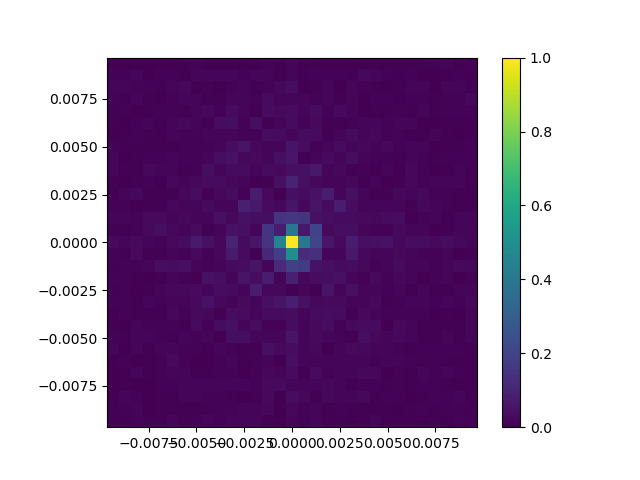

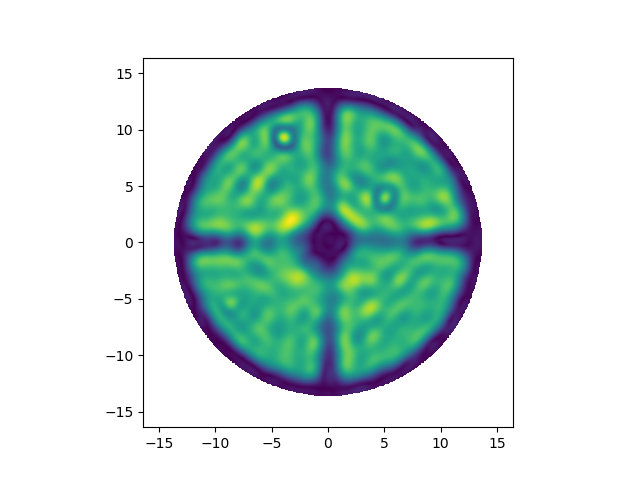

<xarray.Dataset>
Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 442, v_prime: 442,
                      u: 529, v: 529, l: 31, m: 31, ddi: 1)
Coordinates:
  * chan             (chan) float64 1.417e+10
  * ddi              (ddi) <U5 'ddi_0'
  * l                (l) float64 0.009664 0.009019 ... -0.009019 -0.009664
  * m                (m) float64 -0.009664 -0.009019 ... 0.009019 0.009664
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * u                (u) float64 774.6 771.7 768.8 ... -768.8 -771.7 -774.6
  * u_prime          (u_prime) float64 648.5 645.5 642.6 ... -642.6 -645.5
  * v                (v) float64 -774.6 -771.7 -768.8 ... 768.8 771.7 774.6
  * v_prime          (v_prime) float64 -648.5 -645.5 -642.6 ... 642.6 645.5
Dimensions without coordinates: time
Data variables:
    AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
    APERTURE         (time, chan, pol, u, v) complex128 dask.array<chunksize=(1, 1, 1, 133, 265), meta=np.ndarray>
    BEAM             (time, chan, pol, l, m) complex128 dask.array<chunksize=(1, 1, 4, 31, 31), meta=np.ndarray>
    CORRECTED_PHASE  (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
Attributes:
    ant_id:          ant_ea25
    ant_name:        ea25
    ddi:             ddi_0
    telescope_name:  EVLA
    time_centroid:   5170359444.5

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import matplotlib.patches as patches

beforeimage = resultsfolder+'/before.image.zarr'
afterimage = resultsfolder+'/after.image.zarr'

plt.close('all')

chan = 0

ds = xr.open_zarr(afterimage+'/ant_ea25/ddi_0')
wavelength = scipy.constants.speed_of_light/ds.chan.values[chan]
l = ds.l.values
m = ds.m.values
u = ds.u.values*wavelength
v = ds.v.values*wavelength

print(u.min(),u.max())

plt.figure()
plt.imshow(np.abs(ds.BEAM[0,chan,0,:,:]),extent=[l.min(), l.max(), m.min(), m.max()])
plt.colorbar()
plt.show()

circle = patches.Circle((0,0), 12.5, fill=False, color='white', alpha=0.7, linewidth=2)

fig, ax =plt.subplots()
plt.imshow(np.abs(ds.APERTURE[0,chan,0,:,:]),extent=[u.min(), u.max(), v.min(), v.max()])
#ax.add_patch(circle)
plt.show()

ds

In [8]:
from astrohack.panel import panel
panel_model = 'rigid'

before_panel = panel(
    image_name=beforeimage, 
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)
after_panel = panel(
    image_name=afterimage, 
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)

2023-05-02 15:46:42,339 - INFO     - astrohack - (_check_parms.py:119) - Setting default panel_name to ./results/before.panel.zarr
2023-05-02 15:46:42,340 - INFO     - astrohack - (_check_parms.py:119) - Setting default sel_ddi to all
2023-05-02 15:46:42,341 - INFO     - astrohack - (panel.py:123) - Processing ddi_0 for ant_ea25
2023-05-02 15:46:43,457 - INFO     - astrohack - (panel.py:136) - Panel finished processing
2023-05-02 15:46:43,474 - INFO     - astrohack - (_check_parms.py:119) - Setting default panel_name to ./results/after.panel.zarr
2023-05-02 15:46:43,474 - INFO     - astrohack - (_check_parms.py:119) - Setting default sel_ddi to all
2023-05-02 15:46:43,475 - INFO     - astrohack - (panel.py:123) - Processing ddi_0 for ant_ea25
2023-05-02 15:46:44,650 - INFO     - astrohack - (panel.py:136) - Panel finished processing


In [9]:
beforescrews = resultsfolder+'/before-screws.txt'
afterscrews = resultsfolder+'/after-screws.txt'
before_ant = before_panel.get_antenna('ant_ea25', 'ddi_0')
after_ant = after_panel.get_antenna('ant_ea25', 'ddi_0')

before_ant.export_screws(beforescrews, unit="mils")
after_ant.export_screws(afterscrews, unit="mils")

In [10]:

panellist = ['3- 4', '5-27', '5-37', '5-38']
expected  = np.array([-100, 75, 0, 150])

ref_means = np.array([-112.2325,   73.225,    -1.455,   139.04  ])
ref_perce = (ref_means-expected)/expected*100.

def extract_panel_data(fname, panellist):
    data = open(fname, 'r')
    panels = []
    for line in data:
        wrds = line.split('  ')
        if wrds[0] in panellist:
            nmbrs = line.split()
            panel = [0, 0, 0, 0]
            for i in range(4):
                panel[-1-i] = float(nmbrs[-1-i])
            panels.append(panel)
    return np.array(panels)
    
def compare_before_after(panellist, expected): 
    after = extract_panel_data(afterscrews, panellist)
    before = extract_panel_data(beforescrews, panellist)
    diffs = after-before
    means = np.mean(diffs, axis=1)
    percent = (means-expected)/expected*100.
    return means, percent

def test_improvement(pname, diff, unit):
    abso = np.abs(diff)
    if abso > 1e-13:
        if diff < 0:
            print('Panel {0:s} has improved by {1:.20f} {2:s}'.format(pname, abso, unit))
        else:
            print('Panel {0:s} is worse by {1:.20f} {2:s}'.format(pname, abso, unit))
    else:
        print('Panel {0:s} is unchanged'.format(pname))

def is_it_an_improvement(means, percent):
    sumcomp = np.sum(ref_means-means)
    if abs(sumcomp) < 1e-13:
        print('No changes!')
    else:
        print('Results have changed')
        for i in range(4):
            pname = panellist[i]
            if expected[i] == 0:
                diff = np.abs(means[i]-ref_means[i])
                test_improvement(pname, diff, 'mils')
            else:
                diff = np.abs(percent[i]) - np.abs(ref_perce[i])
                test_improvement(pname, diff, '%')


                
means, percent = compare_before_after(panellist, expected)
is_it_an_improvement(means, percent)

No changes!


/tmp/ipykernel_1075979/3164495081.py:5: RuntimeWarning: divide by zero encountered in divide
  ref_perce = (ref_means-expected)/expected*100.
/tmp/ipykernel_1075979/3164495081.py:25: RuntimeWarning: divide by zero encountered in divide
  percent = (means-expected)/expected*100.
